# Rubber Ducky detection and localization Transfer learning on top of RetinaNet

The coco dataset https://cocodataset.org/#explore has segmentation and classification data on many things,
but not on rubber ducks, or even ducks. So this is a novel class that the model has to predict. We will load 5 images of rubber ducks and have the model localize them in the image (say where the duck is in the image by drawing a box around it) 

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
# Install the Object Detection API
# %%bash
# !cd models/research/
# !protoc object_detection/protos/*.proto --python_out=.
# !cp object_detection/packages/tf2/setup.py .
# !python3 -m pip install .

In [4]:
# after installing the above from the protobufs using the object_detection/packages/tf2/setup.py
# we should be able to import from the object detection api

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
# from object_detection.utils import colab_utils # if you're not using colab juse jupyter-innotater

In [5]:
# ! pip install jupyter_innotater
# from jupyter_innotater import *

In [36]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

# the object_detection utils copied here with the other imports for readability 
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
%matplotlib inline

ModuleNotFoundError: No module named 'google.colab'

In [29]:
## Helper function def


def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  # gfile allows us to handle other file system implementations
  #such as HDFS hdfs:// or google cloud storage gs:// 
  # since our files are all local, then we could have used the usual python file opening tools
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)



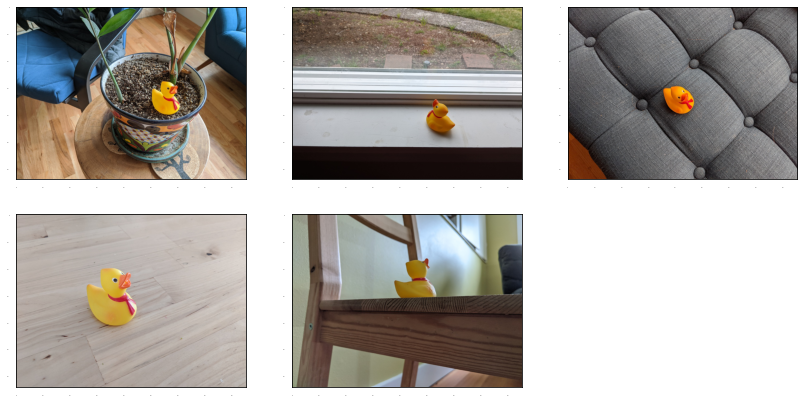

In [30]:
# Load images and visualize
train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
train_images_np = []
for i in range(1, 6):
  image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

normalization_factors = []
for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  normalization_factors.append(train_image_np.shape[:2])
  plt.imshow(train_image_np)
plt.show()


In [31]:
print(train_image_np.shape[:2])
# which is the x and y dims of the image we need to normalize

(640, 853)


In [7]:
# Now we need to annotate the image (draw the bounding box around it) we can use jupyternotebook
#  annotation or colab utils

# ground_truth boxes, means that the real label
from jupyter_innotater import *
gt_boxes = np.zeros((len(train_images_np), 4)) # Initialise bounding boxes as x,y = 0,0, width,height = 0,0

Innotater( ImageInnotation(train_images_np), BoundingBoxInnotation(gt_boxes) )
# the format of the bounding box is x,y,w,h
# where x,y is the topleft cooridnate of the box (the top left corner of the image is the (0,0) cooridnate)
# the more you go right the bigger the x, and the more you go down the bigger the y
# and the w,h are the width and height of the bbox

Innotater(children=(HBox(children=(VBox(children=(ImagePad(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00…

In [33]:
# so now the training images are the duckies images and the labels are the box boundreis we drew
# note that the box we drew is not normalized
print("not normalized bbox", gt_boxes)
print()
gt_boxes_norm = []

# these are the length and width of the image, ie the max values
# all the images are 640 by 853 so we shouldn't need to store everyting in normalization factors
# array, but here it is just in case things are not the same in the future #resiliency
for i, (img_w, img_h) in enumerate(normalization_factors):
    # format is x,y,w,h for gt_box, where x,y is topleft point and w,h are width and height
    # of the bbox we drew, and we want:
    # y_topleft_point, x_topleft_point, y_bottomright_point, x_bottomright point
    # you can think of it as (y_min, x_min, y_max, x_max) since topleft is point (0,0)
    
    #then divide by the w and h to normalize it for x and y respectivly
    
    y_min = gt_boxes[i][1]
    x_min = gt_boxes[i][0]
    y_max = y_min + gt_boxes[i][3]
    x_max = y_max + gt_boxes[i][2]
    
#     normalize
#     y_min, y_max = y_min/ img_h, y_max/ img_h
#     x_min, x_max = x_min/ img_w, x_max/ img_w
    
    norm_vals = [y_min, x_min, y_max, x_max] 
    gt_boxes_norm.append(norm_vals)
    
    
gt_boxes_norm = np.array(gt_boxes_norm)
# current shape is (5,4) we need it to be (5,1,4)
# print(np.shape(gt_boxes_norm))
gt_boxes_norm = np.expand_dims(gt_boxes_norm, 1)

print("normalized bbox", gt_boxes_norm)


not normalized bbox [[506. 276. 107. 125.]
 [503. 343. 108. 144.]
 [339. 284. 155. 127.]
 [260. 185. 203. 243.]
 [365. 144. 174. 167.]]

normalized bbox [[[276. 506. 401. 508.]]

 [[343. 503. 487. 595.]]

 [[284. 339. 411. 566.]]

 [[185. 260. 428. 631.]]

 [[144. 365. 311. 485.]]]


In [34]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}


# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes_norm):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))

  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)

  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


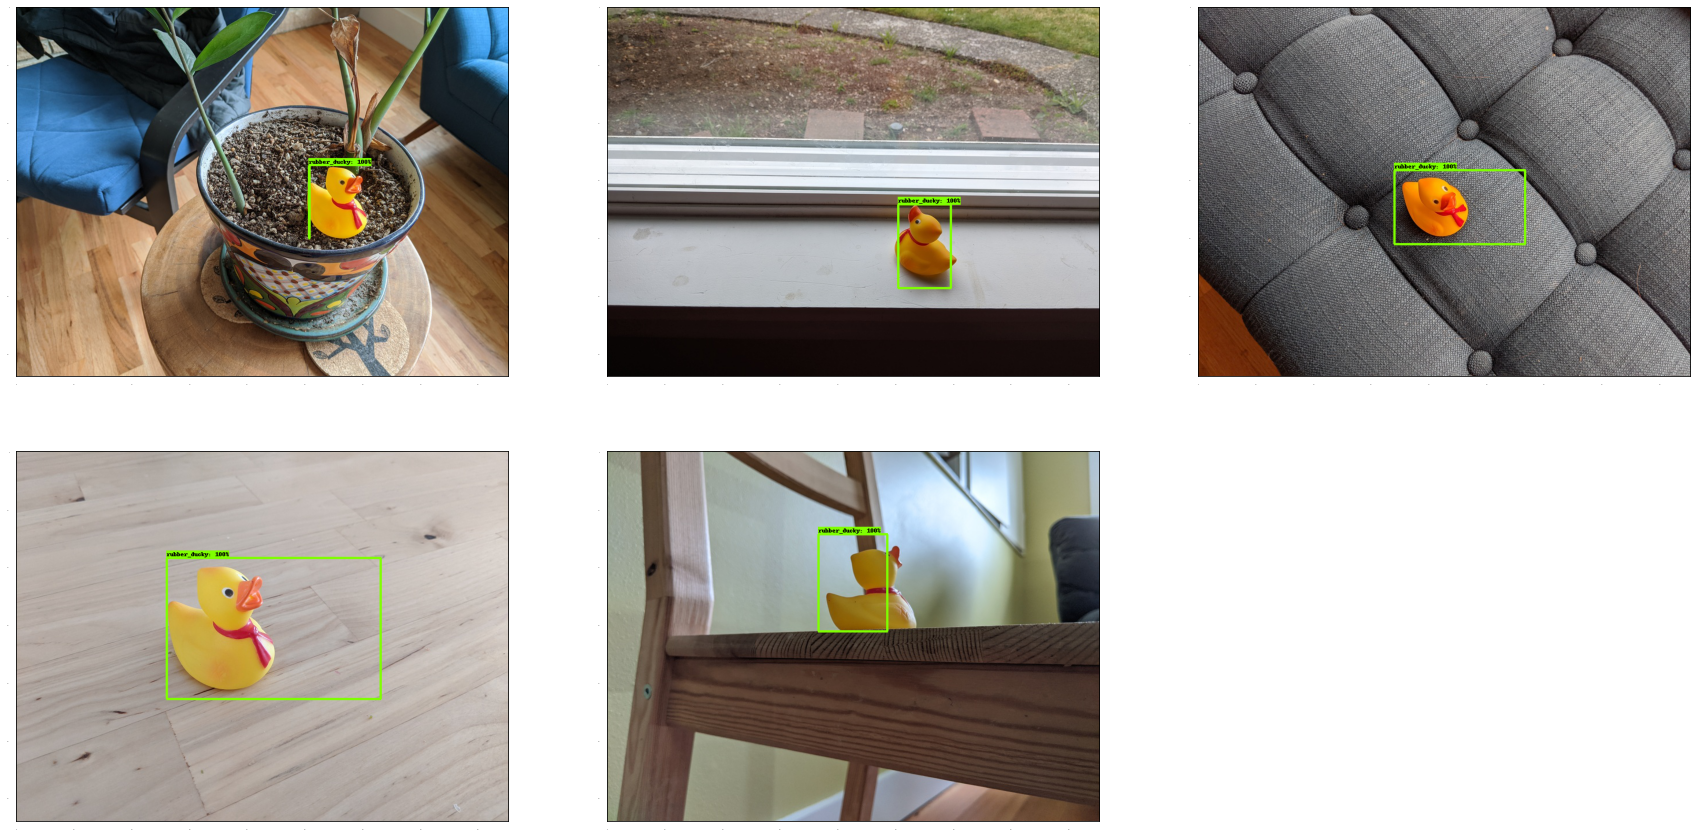

In [35]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

# visualize the training data we created to make sure we did it correctly
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  draw_bounding_box_on_image(
      train_images_np[idx],
      gt_boxes_norm[idx],
      np.ones(shape=[gt_boxes_norm[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()